In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import torch
from torch import nn

from gdeep.models import FFNet

from gdeep.visualisation import  persistence_diagrams_of_activations

from torch.utils.tensorboard import SummaryWriter
from gdeep.data import TorchDataLoader


from gtda.diagrams import BettiCurve

from gtda.plotting import plot_betti_surfaces

from gtda.plotting import plot_diagram

import pandas as pd
import plotly.express as px
from gtda.diagrams import PersistenceEntropy as PE

from gdeep.models import ModelExtractor


In [2]:
writer = SummaryWriter()

In [3]:
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloader(batch_size=32)




In [4]:
from gdeep.pipeline import Pipeline

arch = [28*28,  50, 50, 10]

model = nn.Sequential(nn.Flatten(), FFNet(0, arch= arch ))

In [22]:
from torch.optim import SGD
from torch.optim import Adam

print(model)
loss_fn = nn.CrossEntropyLoss()

pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)

# train the model
#pipe.train(SGD, 3, lr=0.1)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): FFNet(
    (layer0): Linear(in_features=784, out_features=50, bias=True)
    (layer1): Linear(in_features=50, out_features=50, bias=True)
    (layer2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [6]:
from gdeep.models import ModelExtractor



x = next(iter(dl_tr))[0]


In [7]:
from gudhi import SimplexTree as ST
import networkx as nx
import numpy as np


In [8]:




def get_activation_graph(activations,arch, index_batch = 1):
    n_layer = len(arch)
    current_node = 0
    activation_graph = ST()
    edge_list = []
    for i in range(n_layer - 1):
        f = lambda x: (x[0] + current_node, x[1] + current_node)
        G = nx.complete_bipartite_graph(arch[i], arch[i+1])
        l = list(G.edges())
        l = map(f,l)
        edge_list.extend(l)
        current_node += arch[i]
    for edge in edge_list:
        activation_graph.insert(list(edge), 0.0)
    activations_flatten = torch.empty(0)
    for layer in range(n_layer):
        activations_flatten = torch.cat((activations_flatten, activations[layer][index_batch]))
    for neuron in range(activations_flatten.size()[0]):
        activation_graph.insert([neuron], float(activations_flatten[neuron]))
    return activation_graph
    
def gudhi_to_giotto(diagrams_gudhi):
    diagrams_giotto = []
    for diagram in diagrams_gudhi:
        diagram_giotto = []
        for dim, bar in diagram:
            diagram_giotto.append([bar[0],bar[1],dim])
        diagrams_giotto.append(np.array(diagram_giotto))
    return diagrams_giotto


def reverse_diagrams(diagrams):
    diagrams_reversed = []
    for diagram in diagrams:
        diagram_reversed = []
        for b,d,q in diagram:
            diagram_reversed.append([d,b,q])
        diagrams_reversed.append(diagram_reversed)       
    return diagrams_reversed

def get_extended_persistence(model, loss_fn, x):
    me = ModelExtractor(model, loss_fn)
    activations = me.get_activations(x)
    diagrams = []
    for i in range(len(x)):
        L = get_activation_graph(activations, arch, index_batch = i)
        L.extend_filtration()
        pers = L.extended_persistence()
        diagrams.append(pers[3])
    return diagrams
    
def diagrams_accross_training(model, loss_fn, x, n_epochs):
    diagrams = []
    for i in range(n_epochs):
        diagrams.append(get_extended_persistence(model,loss_fn,x))
        pipe.train(SGD, 2, lr=0.1)
    return diagrams

def get_entropy_accross_training(diagrams_accross_training):
    entropy = PE(normalize = True)
    n_epochs = len(diagrams_accross_training)
    n_batch = len(diagrams_accross_training[0])
    E = np.empty([n_epochs,n_batch])
    for epoch in range(n_epochs):
        diagrams_giotto_reversed = reverse_diagrams(gudhi_to_giotto(diagrams_accross_training[epoch]))
        for batch in range(n_batch):
            e = entropy.fit_transform(np.array([diagrams_giotto_reversed[batch]]))[0][0]
            E[epoch][batch] = e
    return E
    
        

## Activation extended persistence

In [9]:
n_epochs = 10
diagrams_training = diagrams_accross_training(model, loss_fn, x, n_epochs)


Epoch 1
-------------------------------
Test Error: 59  [57600/60000]
 Accuracy: 35.2%,                 Avg loss: 0.065984 

Epoch 2
-------------------------------
Test Error: 68  [57600/60000]
 Accuracy: 42.9%,                 Avg loss: 0.063546 

Done!
Epoch 1
-------------------------------
Test Error: 53  [57600/60000]
 Accuracy: 44.5%,                 Avg loss: 0.063071 

Epoch 2
-------------------------------
Test Error: 89  [57600/60000]
 Accuracy: 45.0%,                 Avg loss: 0.062927 

Done!
Epoch 1
-------------------------------
Test Error: 77  [57600/60000]
 Accuracy: 45.6%,                 Avg loss: 0.062743 

Epoch 2
-------------------------------
Test Error: 39  [57600/60000]
 Accuracy: 45.8%,                 Avg loss: 0.062679 

Done!
Epoch 1
-------------------------------
Test Error: 26  [57600/60000]
 Accuracy: 54.9%,                 Avg loss: 0.059834 

Epoch 2
-------------------------------
Test Error: 05  [57600/60000]
 Accuracy: 54.9%,                 Avg

In [ ]:
E = get_entropy_accross_training(diagrams_training)
df_e = pd.DataFrame(E)


In [ ]:
fig = px.line(df_e, labels = {'index' :'epochs', 'value' : 'persistent_entropy_of_first_batch'})
fig.show()

In [ ]:
from gtda.diagrams import PairwiseDistance
dist = PairwiseDistance(metric = 'bottleneck')


In [ ]:
diagrams = gudhi_to_giotto(diagrams_training[9]) 
distance_matrix = dist.fit_transform(diagrams)

## Study of overfitting on one batch

In [14]:
from torch import optim
n_epochs = 200
optimizer = optim.SGD(model.parameters(), lr=0.3)
image , labels = next(iter(dl_tr))
diagrams_overfitting = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output = model(image)
    loss = loss_fn(output,labels)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        diagrams_overfitting.append(get_extended_persistence(model, loss_fn, image))

In [18]:
births = []
deaths = []
epochs = []
batchs = []

n_batch = 32
for epoch in range(20):
    diagrams_training_giotto = gudhi_to_giotto(diagrams_overfitting[epoch])
    for batch in range(n_batch):
        for b,d,q in diagrams_training_giotto[batch]:
            births.append(b)
            deaths.append(d)
            epochs.append(epoch)
            batchs.append(batch)
            
data = {'birth' : births , 'death' : deaths, 'epoch': epochs, 'batch' : batchs}
df = pd.DataFrame (data, columns = ['birth','death','epoch', 'batch'])



for epoch in range(20):
    fig = px.scatter(df[df['epoch'] == epoch], x="birth", y="death",  color="batch",
          range_x=[-100, 0], range_y=[-100,0])
    fig.write_image('barcode_' + str(epoch) + '_overfitting' + '.png')
        

## Generate video of barcodes during training

In [ ]:
births = []
deaths = []
epochs = []
batchs = []

n_batch = 32
for epoch in range(n_epochs):
    diagrams_training_giotto = gudhi_to_giotto(diagrams_training[epoch])
    for batch in range(n_batch):
        for b,d,q in diagrams_training_giotto[batch]:
            births.append(b)
            deaths.append(d)
            epochs.append(epoch)
            batchs.append(batch)
        

In [ ]:
data = {'birth' : births , 'death' : deaths, 'epoch': epochs, 'batch' : batchs}
df = pd.DataFrame (data, columns = ['birth','death','epoch', 'batch'])


In [ ]:


for epoch in range(n_epochs):
    fig = px.scatter(df[df['epoch'] == epoch], x="birth", y="death",  color="batch",
          range_x=[-100, 0], range_y=[-100,0])
    fig.write_image('barcode_' + str(epoch) + '.png')

In [ ]:
fig.write_html("video_barcodes.html")

In [ ]:
df2 = df[df['batch'] == 0]

In [ ]:
fig.write_image('barcodes.png')

In [ ]:
image , labels = next(iter(dl_tr))

## Adversarial examples


In [10]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)
device = "cpu"

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/Users/berkouknicolas/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epsilon: 0	Test Accuracy = 6443 / 10000 = 0.6443
Epsilon: 0.05	Test Accuracy = 4085 / 10000 = 0.4085
Epsilon: 0.1	Test Accuracy = 3265 / 10000 = 0.3265
Epsilon: 0.15	Test Accuracy = 3072 / 10000 = 0.3072
Epsilon: 0.2	Test Accuracy = 2985 / 10000 = 0.2985
Epsilon: 0.25	Test Accuracy = 2922 / 10000 = 0.2922
Epsilon: 0.3	Test Accuracy = 2887 / 10000 = 0.2887


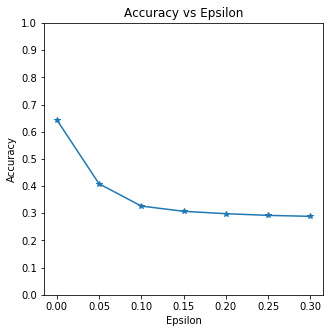

In [12]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [33]:
epsilon = 0.1

# Send the data and label to the device
data, target = next(iter(dl_tr))

    
# Set requires_grad attribute of tensor. Important for Attack
data.requires_grad = True

# Forward pass the data through the model
output = model(data)
init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    
# Calculate the loss
loss = loss_fn(output, target)

# Zero all existing gradients
model.zero_grad()

# Calculate gradients of model in backward pass
loss.backward()

# Collect datagrad
data_grad = data.grad.data

# Call FGSM Attack
perturbed_data = fgsm_attack(data, epsilon, data_grad)

# Re-classify the perturbed image
output = model(perturbed_data)

# Check for success
final_pred = output.max(1, keepdim=True)[1] 

In [63]:
diagrams_normal = get_extended_persistence(model, loss_fn, data)

In [64]:
diagrams_adversarial = get_extended_persistence(model, loss_fn, perturbed_data)

In [74]:
import gudhi
adversarial_distortion = []
for i in range(len(diagrams_normal)):
    d1 = [[bar[1],bar[0]] for dim,bar in diagrams_normal[i] ]
    d2 = [[bar[1],bar[0]] for dim,bar in diagrams_adversarial[i] ]
    dist = gudhi.bottleneck_distance(d1,d2)
    adversarial_distortion.append(dist)

In [86]:
entropy_normal = get_entropy_accross_training([diagrams_normal])
entropy_adversarial = get_entropy_accross_training([diagrams_adversarial])

In [82]:
import plotly.express as px
df = adversarial_distortion
fig = px.scatter(df, color= adversarial_result)
fig.show()


In [102]:
df2 = [entropy_normal[0], entropy_adversarial[0]]
fig2 = px.line(df2)
fig2.show()

In [100]:
entropy_normal[0][adversarial_result == 1]

array([], shape=(0, 32), dtype=float64)

In [101]:
adversarial_result == 1

False

In [111]:
init_pred, target

(tensor([[5],
         [0],
         [4],
         [8],
         [9],
         [8],
         [8],
         [5],
         [4],
         [4],
         [5],
         [5],
         [5],
         [6],
         [5],
         [7],
         [7],
         [8],
         [6],
         [9],
         [4],
         [0],
         [9],
         [8],
         [6],
         [8],
         [4],
         [5],
         [7],
         [7],
         [8],
         [8]]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
         1, 2, 4, 3, 2, 7, 3, 8]))

In [120]:
[int(target[i] == init_pred[i]) for i in range(len(target))]

[1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1]